# **Part Nº 1**

### **1.1 Install Dependencies**

In [7]:
# %pip install tensorflow==2.4.1 tensorflow-gpu==2.4.1 opencv-python matplotlib

### **1.2 Import Dependencies**

In [8]:
import os
import cv2
import random
import numpy as np 
from matplotlib import pyplot as plt
from datetime import datetime

In [9]:
#Import tensorflow API
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten

### **1.3 Set GPU Growth**

In [10]:
#Avoid OOM errors by setting GPU Memory Consumption Grotwh
#Acessando todas as gpus da máquina
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)

# Liberando o crescimento de uso da memória 
for gpu in gpus:
  print(gpu)
  tf.config.experimental.set_memory_growth(gpu, True)

[]


2022-11-28 15:23:53.678488: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-11-28 15:23:53.680641: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-11-28 15:23:53.712441: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-11-28 15:23:53.712472: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jarvis): /proc/driver/nvidia/version does not exist


### **1.4 Create Folder Structures**

In [11]:
#Setup paths
#Teremos 3 pastas base, anchor (imagem sendo colocada a prova), postive (imagem de pessoas que queremos verificar), negative (imagens de pessoas que não queremos identificar)
#APP_PATH = '/content/drive/MyDrive/Mestrado/CADEIRAS/Aprendizagem de Maquina/facial-recognition-app'
APP_PATH = '/home/gabriel/Documentos/mestrado/am/notebooks/face-recognition-app'
POS_PATH = os.path.join(APP_PATH, 'data', 'positive')
NEG_PATH = os.path.join(APP_PATH, 'data', 'negative')
ANC_PATH = os.path.join(APP_PATH, 'data', 'anchor')

In [12]:
#Criando diretórios
dirnames = [POS_PATH, NEG_PATH, ANC_PATH]
for dir in dirnames:
  if(not os.path.exists(dir)):
    print('Creating directory: ', dir)
    os.makedirs(dir)

# **Part Nº 2**

## **2. Collect Positives and Anchors**

### **2.1 Untar Labelled Faces int the Wild Dataset**

#### **1.   Acess http://vis-www.cs.umass.edu/lfw/**
#### **2.   At the menu, go to Download option**
#### **3.   Download database option 'All images as gzipped tar file'** 

In [13]:
# http://vis-www.cs.umass.edu/lfw/
# Uncompress Tar GZ Labelled Faces in the Wild Dataset
TGZ_PATH = os.path.join(APP_PATH, 'lfw.tgz')
# !tar -xf '/content/drive/MyDrive/Mestrado/CADEIRAS/Aprendizagem de Maquina/facial-recognition-app/lfw.tgz' -C '/content/drive/MyDrive/Mestrado/CADEIRAS/Aprendizagem de Maquina/facial-recognition-app/'

In [14]:
def move_to_negative_path():
    # Move LFW Images to the following repository data/negative
    for directory in os.listdir('lfw'):
        for file in os.listdir(os.path.join('lfw', directory)):
            print(file)
            EX_PATH = os.path.join('lfw', directory, file)
            NEW_PATH = os.path.join(NEG_PATH, file)
            os.replace(EX_PATH, NEW_PATH)

In [15]:
#move_to_negative_path()

### **2.2 Collect Positive and Anchor Classes**

In [16]:
# Import uuid library to generate unique image names
import uuid

In [17]:
WEBCAM_DEVICE_NUMBER = 0

In [18]:
# Esablish a connection to the webcam
# If you get a empty error or can't open camera by index error, try another number (ex. 4)
cap = cv2.VideoCapture(WEBCAM_DEVICE_NUMBER)
while cap.isOpened():
  ret, frame = cap.read()

  # Cut down frame to 250x250px
  frame = frame[120:120+250, 200:200+250, : ]

  # Show image back to screen 
  cv2.imshow('Image Collection', frame)

  # Collect Anchors
  if(cv2.waitKey(1) & 0XFF == ord('a')):
    # Create the unique file path
    imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
    # Write out anchor image
    cv2.imwrite(imgname, frame)


  # Collect Positives
  elif(cv2.waitKey(1) & 0XFF == ord('p')):
    # Create the unique file path
    imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
    # Write out positive image
    cv2.imwrite(imgname, frame)

  # Breaking gracefully
  elif(cv2.waitKey(1) & 0XFF == ord('q')):
    break

# Release the webcam
cap.release()
# Close the image show frame
cv2.destroyAllWindows()


In [10]:
frame.shape

(250, 250, 3)

# Part 3

## **3. Load and Preprocess Images**

### **3.1 Get Image Directories**

In [9]:
# Getting the same number of images per folder
# Create a dataset generator for each folder
anchor = tf.data.Dataset.list_files(ANC_PATH + '/*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH + '/*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH + '/*.jpg').take(300)


2022-11-27 21:07:52.408739: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-27 21:07:52.409551: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set


### **3.2 Preprocessing - Scale and Resize**

In [10]:
def pre_process(file_path):
    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load the image
    img = tf.io.decode_jpeg(byte_img)

    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (100, 100))
    # Scale image to be between 0 and 1
    img = img / 255.0

    # Return image preprocessed
    return img

### **3.3 Create Labelled Dataset**

In [11]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [12]:
data

<ConcatenateDataset shapes: ((), (), ()), types: (tf.string, tf.string, tf.float32)>

In [13]:
samples = data.as_numpy_iterator()
samples.next()

(b'/home/gabriel/Documentos/mestrado/am/notebooks/face-recognition-app/data/anchor/fe8ae712-6bed-11ed-886b-073aaa4b2cb1.jpg',
 b'/home/gabriel/Documentos/mestrado/am/notebooks/face-recognition-app/data/positive/2a82f9d2-6bef-11ed-886b-073aaa4b2cb1.jpg',
 1.0)

In [14]:
example = samples.next()

### **3.4 Build Train and Test Partition**

In [15]:
def pre_process_twin(input_img, validation_img, label):
	return (pre_process(input_img), pre_process(validation_img), label)

In [16]:
pre_process_twin(*example)

(<tf.Tensor: shape=(100, 100, 3), dtype=float32, numpy=
 array([[[0.25      , 0.25      , 0.25      ],
         [0.2509804 , 0.2509804 , 0.2509804 ],
         [0.25857842, 0.25857842, 0.25857842],
         ...,
         [0.25637254, 0.25833333, 0.25735295],
         [0.21715686, 0.225     , 0.22107843],
         [0.21372549, 0.22156863, 0.21764706]],
 
        [[0.24411765, 0.25      , 0.24705882],
         [0.2492647 , 0.2492647 , 0.2492647 ],
         [0.2509804 , 0.2509804 , 0.2509804 ],
         ...,
         [0.25686276, 0.25882354, 0.25784314],
         [0.21176471, 0.21960784, 0.21568628],
         [0.18995099, 0.19779412, 0.19387256]],
 
        [[0.24117647, 0.24117647, 0.23529412],
         [0.24019608, 0.24019608, 0.2357843 ],
         [0.24705882, 0.24705882, 0.24705882],
         ...,
         [0.2629902 , 0.26936275, 0.26617646],
         [0.24019608, 0.24803922, 0.24411765],
         [0.22279412, 0.23063725, 0.22671568]],
 
        ...,
 
        [[0.21397059, 0.21789216

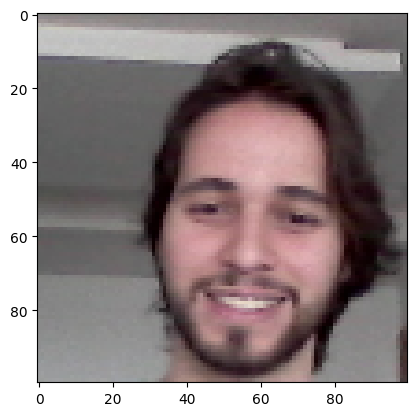

In [17]:

res = pre_process_twin(*example)
plt.imshow(res[1])

In [18]:
# Build dataloader pipeline
data = data.map(pre_process_twin)
data = data.cache()
data = data.shuffle(buffer_size=10000)

In [30]:
# Training partition
# Recovering 70% of the data for train
train_data = data.take(round(len(data)*.7))
# passing data as batches of 16 images
train_data = train_data.batch(16)
# starts pre-processing the next set of images to avoid bottleneck
train_data = train_data.prefetch(8)

In [31]:
# Testing partition
# skip the first 420 images
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [32]:
train_samples = train_data.as_numpy_iterator()
train_sample = train_samples.next()
# We have 16 images inside each example now
len(train_sample[0])

2022-11-27 21:10:51.372121: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-11-27 21:10:51.394779: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2899885000 Hz


16

# Part 4

### **4. Model Engineering**

![Siamese Neural Network](./siamese-neural-network.png)

### 4.1 Build Embedding Layer

In [19]:
def make_embedding(): 
    # We are going to work with 100x100px, so the numbers will not be exactly the same however it's not a problem.
    inp = Input(shape=(100,100,3), name='input_image')
    
    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third block 
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    # Flatting a 3-dimension into a one-dimension
    f1 = Flatten()(c4)
    # Fully connected layer
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [20]:
embedding = make_embedding()
embedding.summary()

Model: "embedding"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_image (InputLayer)     [(None, 100, 100, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 91, 91, 64)        19264     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 46, 46, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 40, 40, 128)       401536    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 20, 20, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 17, 17, 128)       262272    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 9, 9, 128)         0 

### 4.2 Build Distance Layer

In [21]:
# Siamese L1 Distance class
class L1Dist(Layer):
    
    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()
       
    # Magic happens here - similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [22]:
l1 = L1Dist()
l1

### 4.3 Make Siamese Model

In [23]:
def make_siamese_model(): 
    
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))
    
    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=(100,100,3))
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [24]:
siamese_model = make_siamese_model()
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_img (InputLayer)          [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
validation_img (InputLayer)     [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
embedding (Functional)          (None, 4096)         38960448    input_img[0][0]                  
                                                                 validation_img[0][0]             
__________________________________________________________________________________________________
distance (L1Dist)               (None, 4096)         0           embedding[0][0]     

## 5. Training

### 5.1 Setup Loss and Optimizer

In [30]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [31]:
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001

### 5.2 Estabilsh Checkpoints

In [32]:
#Criando diretórios
checkpoint_dir = os.path.join(APP_PATH , 'training_checkpoints')
if(not os.path.exists(checkpoint_dir)):
    print('Creating checkpoint directory')
    os.makedirs(checkpoint_dir)

checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)
# To reload from the checkpoint you can use model.load('path_to_checkpoint'). This will load the pre trained weights into the existing model

Creating checkpoint directory


### 5.3 Build Train Step Function

The basic flow for training on one batch is as follow:
1. Make a prediction
2. Calculate loss
3. Derive gradients
4. Calculate new weights and apply

In [33]:
# tf.function compiles a function into a callable TensorFlow graph
@tf.function
def train_step(batch):
    
    # Record all of our operations 
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        # Need to set training to True because certain layers only activate when is training
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
        
    # Return loss
    return loss

### 5.4 Build Training Loop

In [25]:

# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

In [35]:
# While the train_step function was focused on training for one batch, the loop here will be used to iterate over every batch in the dataset.

def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Creating a metric object 
        r = Recall()
        p = Precision()
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            loss = train_step(batch)
            yhat = siamese_model.predict(batch[:2])
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat)
            progbar.update(idx+1)
        print(loss.numpy(), r.result().numpy(), p.result().numpy())
        
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

    date = str(datetime.now())[:19]
    # Save weights
    siamese_model.save('siamese_model_' + date + '.h5')

### 5.5 Train the Model

In [27]:
EPOCHS = 50
ALREADY_TRAINED = True

In [37]:
if not ALREADY_TRAINED: 
    train(train_data, EPOCHS)


 Epoch 1/50
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
27/27 [==============================] - 371s 14s/step
0.63764304 0.72596157 0.76649743

 Epoch 2/50
27/27 [==============================] - 400s 15s/step
0.18224481 0.93838865 0.94736844

 Epoch 3/50
27/27 [==============================] - 412s 15s/step
0.019018926 0.98067635 0.99509805

 Epoch 4/50
27/27 [==============================] - 347s 13s/step
0.014329029 0.98571426 0.9951923

 Epoch 5/50
27/27 [==============================] - 348s 13s/step
0.036260057 0.9951923 1.0

 Epoch 6/50
27/27 [==============================] - 378s 14s/step
0.06935164 0.9953917 1.0

 Epoch 7/50
27/27 [==============================] - 355s 13s/step
3.1055337e-05 0.99509805 1.0

 Epoch 8/50
27/27 [==============================] - 398s 15s/step
1.968469e-05 0.9951456 1.0

 Epoch 9/50
27/27 [==============================] - 512s 19s

# Part 6

## 6. Evaluate Model

### 6.1 Import Metrics

In [33]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

### 6.2 Make Predictions

In [34]:
# Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [35]:
y_hat = siamese_model.predict([test_input, test_val])

In [36]:
# Post processing the results 
[1 if prediction > 0.5 else 0 for prediction in y_hat ]

[1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0]

In [37]:
y_true

array([0., 1., 1., 1., 0., 1., 0., 0., 1., 1., 0., 0., 1., 0., 1., 0.],
      dtype=float32)

### 6.3 Calculate Metrics

#### 6.3.1 Calculating for one batch

In [38]:
# Creating a metric object 
# Recall shows what proportion of actual positives were identified correctly.
m = Recall()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

0.5

In [39]:
# Creating a metric object 
# Precision demonstrates what proportion of positive identifications were actually correct.
m = Precision()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

0.5

#### Calculating for all batchs

In [40]:
r = Recall()
p = Precision()

for test_input, test_val, y_true in test_data.as_numpy_iterator():
    yhat = siamese_model.predict([test_input, test_val])
    r.update_state(y_true, yhat)
    p.update_state(y_true,yhat) 

print(r.result().numpy(), p.result().numpy())

0.3152174 0.51785713


### 6.4 Viz Results

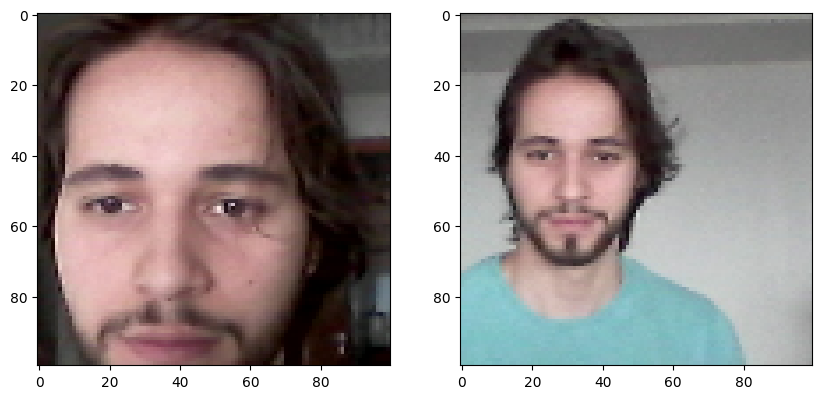

In [46]:
# Set plot size 
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[0])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[0])

# Renders cleanly
plt.show()

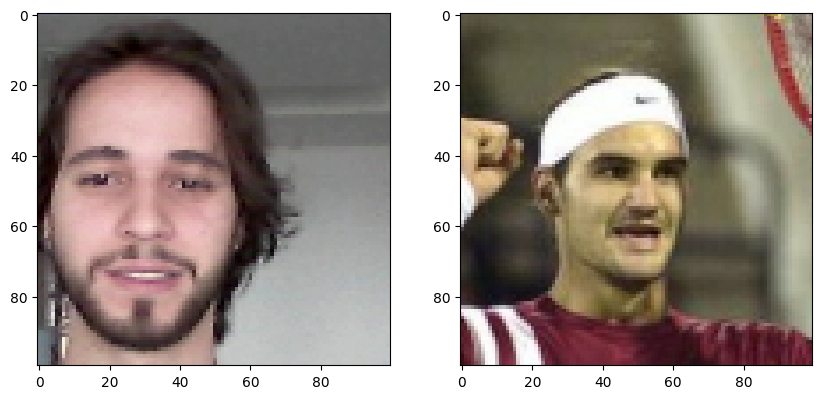

In [47]:
# Set plot size 
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[1])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[1])

# Renders cleanly
plt.show()

# Part 7

## 7. Save Model

In [63]:

date = str(datetime.now())[:19]
# Save weights
siamese_model.save('siamese_model_' + date + '.h5')

In [42]:
# Reload model 
siamese_model = tf.keras.models.load_model('siamese_model_300_50.h5', compile=False, 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [43]:
# Make predictions with reloaded model
siamese_model.predict([test_input, test_val])

array([[6.7008874e-09],
       [9.9981833e-01],
       [9.6452594e-01],
       [9.9999952e-01]], dtype=float32)

In [44]:
# View model summary
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_img (InputLayer)          [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
validation_img (InputLayer)     [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
embedding (Functional)          (None, 4096)         38960448    input_img[0][0]                  
                                                                 validation_img[0][0]             
__________________________________________________________________________________________________
l1_dist_3 (L1Dist)              (None, 4096)         0           embedding[0][0]     

# Part 8

## 8. Real Time Test

### 8.1 Verification Function

![Verification Explanation](verification-explanation.png)

Next steps:
1. create directory application_data
2. create directory application_data/verification_images
3. create directory application_data/input_image
4. Go to data, then positive samples, then and grap some images (50) and copy them to the verification_images

In [45]:
os.listdir(os.path.join('application_data', 'verification_images'))

['47de7408-6bef-11ed-886b-073aaa4b2cb1.jpg',
 'e9a4fe94-6bee-11ed-886b-073aaa4b2cb1.jpg',
 '44422b2d-6bef-11ed-886b-073aaa4b2cb1.jpg',
 '0806654f-6bef-11ed-886b-073aaa4b2cb1.jpg',
 'f8e2a62b-6bee-11ed-886b-073aaa4b2cb1.jpg',
 '8eafe1ca-6bee-11ed-886b-073aaa4b2cb1.jpg',
 'e393aa9f-6bee-11ed-886b-073aaa4b2cb1.jpg',
 '6559047c-6bef-11ed-886b-073aaa4b2cb1.jpg',
 'ecf7c458-6bee-11ed-886b-073aaa4b2cb1.jpg',
 '61d7a79c-6bef-11ed-886b-073aaa4b2cb1.jpg',
 'e0374b3a-6bee-11ed-886b-073aaa4b2cb1.jpg',
 'ebd9deb3-6bee-11ed-886b-073aaa4b2cb1.jpg',
 '0593c042-6bef-11ed-886b-073aaa4b2cb1.jpg',
 '42e69ab2-6bef-11ed-886b-073aaa4b2cb1.jpg',
 'd10aded3-6bee-11ed-886b-073aaa4b2cb1.jpg',
 '0209dd6a-6bef-11ed-886b-073aaa4b2cb1.jpg',
 '0209dd6d-6bef-11ed-886b-073aaa4b2cb1.jpg',
 'd23265e3-6bee-11ed-886b-073aaa4b2cb1.jpg',
 'fe4494ce-6bee-11ed-886b-073aaa4b2cb1.jpg',
 '8d44770f-6bee-11ed-886b-073aaa4b2cb1.jpg',
 '0806654d-6bef-11ed-886b-073aaa4b2cb1.jpg',
 '4ceab0ac-6bef-11ed-886b-073aaa4b2cb1.jpg',
 '247cfc62

In [46]:
def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = pre_process(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = pre_process(os.path.join('application_data', 'verification_images', image))
        
        # Make Predictions 
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    # Detection Threshold: Metric above which a prediciton is considered positive 
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions / total positive samples 
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images'))) 
    verified = verification > verification_threshold
    
    return results, verified

### 8.2 OpenCV Real Time Verification

In [55]:
# Increase thresholds to avoid false positives
# Detection Threshold: Metric above which a prediciton is considered positive 
# Verification Threshold: Proportion of positive predictions / total positive samples 
DETECTION_THRESHOLD = 0.8
VERIFICATION_THRESHOLD = 0.7


In [54]:
cap = cv2.VideoCapture(WEBCAM_DEVICE_NUMBER)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250,200:200+250, :]
    
    cv2.imshow('Verification', frame)
    
    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        # Save input image to application_data/input_image folder 
        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        
        # Run verification
        results, verified = verify(siamese_model, DETECTION_THRESHOLD, VERIFICATION_THRESHOLD)
        print(verified)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

False
False
True


In [56]:
results

[array([[0.9977186]], dtype=float32),
 array([[0.979723]], dtype=float32),
 array([[0.9998375]], dtype=float32),
 array([[0.46436992]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.99287206]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.99571085]], dtype=float32),
 array([[0.79686785]], dtype=float32),
 array([[0.98596525]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.9776808]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.99974227]], dtype=float32),
 array([[0.9997016]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.9986577]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.99987364]], dtype=float32),
 array([[0.08966964]], dtype=float32),
 array([[0.9921473]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.99999917]], dtype=float32),
 array([[0.89544797]], dtype=float32),
 array([[0.98206806]], dtype=float32),
 array([[0.9807397]], dtype

In [58]:
40 / 50

0.8

In [59]:
# Tryng improve threshold
np.sum(np.squeeze(results) > 0.9)

45

## NEXT STEPS: Build the Facial Recognizer APP with Kivy